# EXEMPLE DE FONCTIONNEMENT DE LA FONCTION

### Etape 1- Téléchargement des packages

In [4]:
# Importation des packages 

%matplotlib inline

import numpy as np
import pandas as pd
import urllib.request
import zipfile
from tqdm import tqdm
from pyproj import Proj, transform
# commande d'installation de cartopy : "conda install -c conda-forge cartopy"
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import imageio
import ensae2019

### Etape 2- Chargement des données 

In [4]:
#  Chargement des données + Dézippage 

import requests

headers = {
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'DNT': '1',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
    'Referer': 'http://www.georisques.gouv.fr/dossiers/irep/telechargement',
    'Accept-Encoding': 'gzip, deflate',
    'Accept-Language': 'en-US,en;q=0.9,fr-FR;q=0.8,fr;q=0.7,ru;q=0.6,de;q=0.5,pt;q=0.4',
}

url = 'http://www.georisques.gouv.fr/irep/data/'
for i in tqdm(range(2003,2018)):
    response = requests.get(url+str(i), headers=headers, verify=False)
    with open('/Users/boisselcamille/'+str(i)+'.zip', mode='wb') as localfile:
        localfile.write(response.content)
        
    with zipfile.ZipFile('/Users/boisselcamille/'+str(i)+'.zip',"r") as zip_ref:
        zip_ref.extractall("/Users/boisselcamille/data/"+str(i)+'/')

100%|██████████| 15/15 [00:52<00:00,  5.87s/it]


### Etape 3- Modification des données 

In [2]:
### Création du dataframe de travail 

## Initialisation du jeu de données
# Chargement des données
df = pd.read_csv("./data/2003/Prelevements.csv") 
df = df.fillna('0')
df2 = pd.read_csv("./data/2003/etablissements.csv")
df2 = df2.fillna('0')

# Restriction des colonnes du dataframe aux données d'intérêt
df2 = df2[['Identifiant','Nom_Etablissement','Coordonnees_X','Coordonnees_Y']]

# Renommage les colonnes d'intérêt pour pouvoir différencier les données selon les années + Reformatage
df = df.rename({'Prelevements_eaux_souterraines': 'Prelevements_eaux_souterraines_2003'}, axis='columns')  
df["Prelevements_eaux_souterraines_2003"]=df["Prelevements_eaux_souterraines_2003"].apply(pd.to_numeric)

df = df.rename({'Prelevements_eaux_surface': 'Prelevements_eaux_surface_2003'}, axis='columns')
df["Prelevements_eaux_surface_2003"]=df["Prelevements_eaux_surface_2003"].apply(pd.to_numeric)

df = df.rename({'Prelevements_reseau_distribution': 'Prelevements_reseau_distribution_2003'}, axis='columns')
df["Prelevements_reseau_distribution_2003"]=df["Prelevements_reseau_distribution_2003"].apply(pd.to_numeric)

df = df.rename({'Prelevements_mer': 'Prelevements_mer_2003'}, axis='columns')
df["Prelevements_mer_2003"]=df["Prelevements_mer_2003"].apply(pd.to_numeric)

# Création d'une colonne supplémentaire avec les prélévements totaux
df['Prelevements_totaux_2003']=df['Prelevements_eaux_souterraines_2003']+df['Prelevements_eaux_surface_2003']+df['Prelevements_reseau_distribution_2003']+df['Prelevements_mer_2003']

# Fusion des deux bases pour centraliser les informations. Ce df sert de support à l'étape suivante. 
df = df.merge(df2, on="Identifiant")


## Ajouts successifs des années suivantes: sur le même modèle que précédemment 

for i in tqdm(range(2004,2018)):
    
    # Chargement des données de l'année considérée + mise en forme des df 
    df_temp = pd.read_csv("./data/"+str(i)+"/Prelevements.csv")
    df_temp = df_temp.fillna('0') # on remplit les cases NA tout de suite 
    df2_temp = pd.read_csv("./data/"+str(i)+"/etablissements.csv")
    df2_temp = df2_temp.fillna('0')
    
    # Restriction du 2e df aux données d'intérêt 
    df2_temp = df2_temp[['Identifiant','Nom_Etablissement','Coordonnees_X','Coordonnees_Y']]
    
    # Reformatage des colonnes de prélèvement 
    df_temp = df_temp.rename({'Prelevements_eaux_souterraines': 'Prelevements_eaux_souterraines_'+str(i)}, axis='columns')
    df_temp["Prelevements_eaux_souterraines_"+str(i)]=df_temp["Prelevements_eaux_souterraines_"+str(i)].apply(pd.to_numeric)
    
    df_temp = df_temp.rename({'Prelevements_eaux_surface': 'Prelevements_eaux_surface_'+str(i)}, axis='columns')
    df_temp["Prelevements_eaux_surface_"+str(i)]=df_temp["Prelevements_eaux_surface_"+str(i)].apply(pd.to_numeric)
    
    df_temp = df_temp.rename({'Prelevements_reseau_distribution': 'Prelevements_reseau_distribution_'+str(i)}, axis='columns')
    df_temp["Prelevements_reseau_distribution_"+str(i)]=df_temp["Prelevements_reseau_distribution_"+str(i)].apply(pd.to_numeric)
    
    df_temp = df_temp.rename({'Prelevements_mer': 'Prelevements_mer_'+str(i)}, axis='columns')
    df_temp["Prelevements_mer_"+str(i)]=df_temp["Prelevements_mer_"+str(i)].apply(pd.to_numeric)
    
    # Ajout de la colonne des prélèvements totaux 
    df_temp['Prelevements_totaux_'+str(i)]=df_temp['Prelevements_eaux_souterraines_'+str(i)]+df_temp['Prelevements_eaux_surface_'+str(i)]+df_temp['Prelevements_reseau_distribution_'+str(i)]+df_temp['Prelevements_mer_'+str(i)]
    
    # Fusion des deux df temporaires pour ajout final au df de sortie 
    df_temp = df_temp.merge(df2_temp, on="Identifiant")
    
    # C'est ici que se fait l'ajout des données de l'année i dans le df de sortie 
    df = df.merge(df_temp, on=["Identifiant","Nom_Etablissement_x","LLX","LLY"], how="outer") 
    
df = df.fillna(0)  #Le merge outer fait apparaitre des valeurs manquantes (NaN), on les remplace par 0 


100%|██████████| 14/14 [00:07<00:00,  1.42it/s]


In [202]:
# Vérification de la sortie précédente 
df.sort_values(by=['Prelevements_totaux_2010'], axis=0).head(10)


0    868014.0
1         0.0
2    440500.0
3         0.0
4     94300.0
Name: Prelevements_totaux_2010, dtype: float64


### Etape 4- Exemple de sortie 

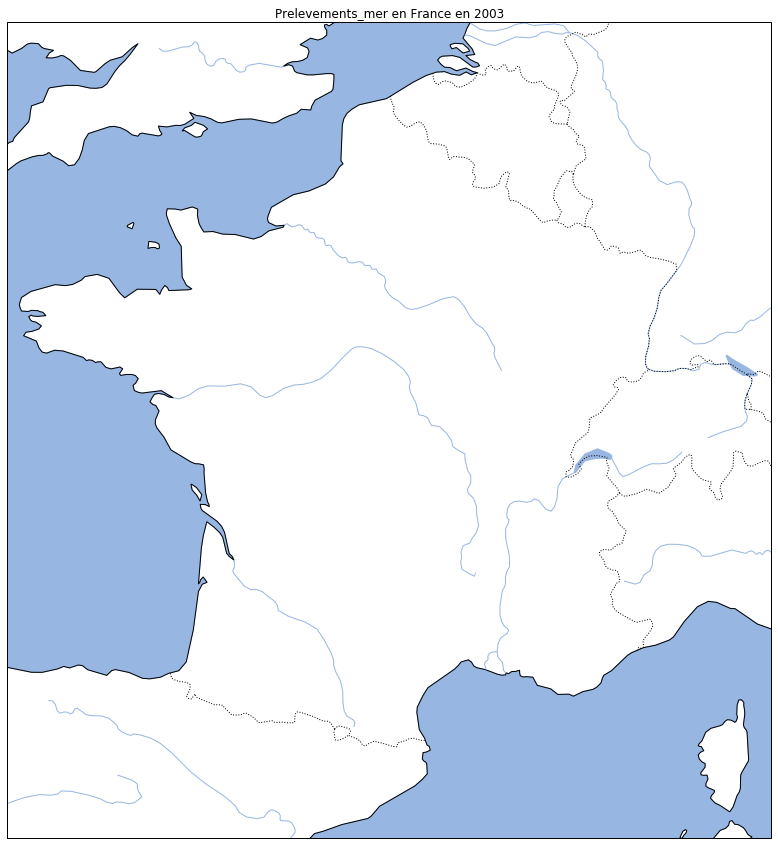

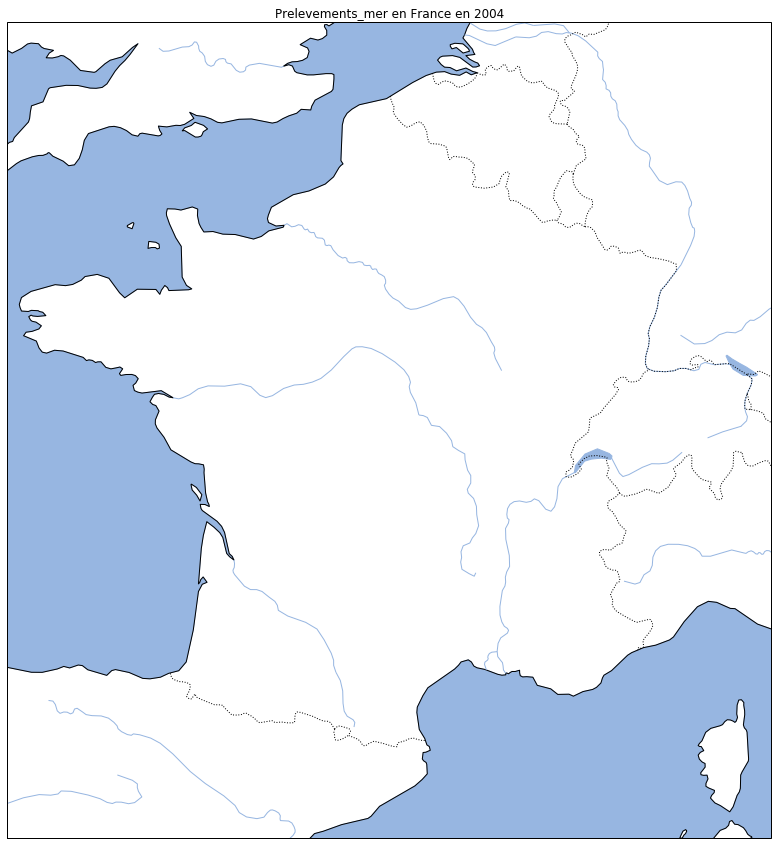

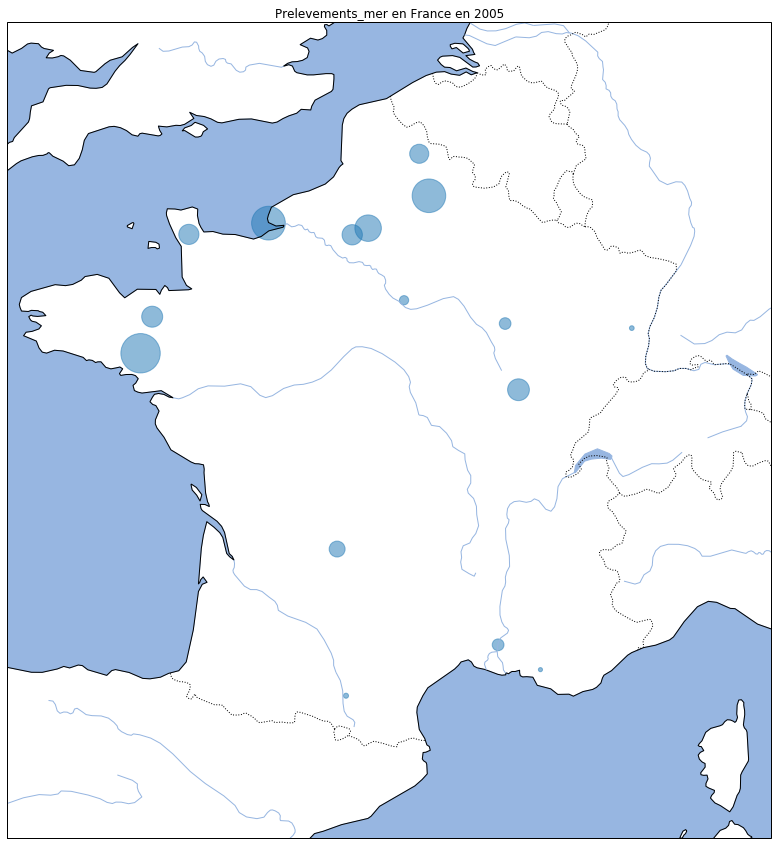

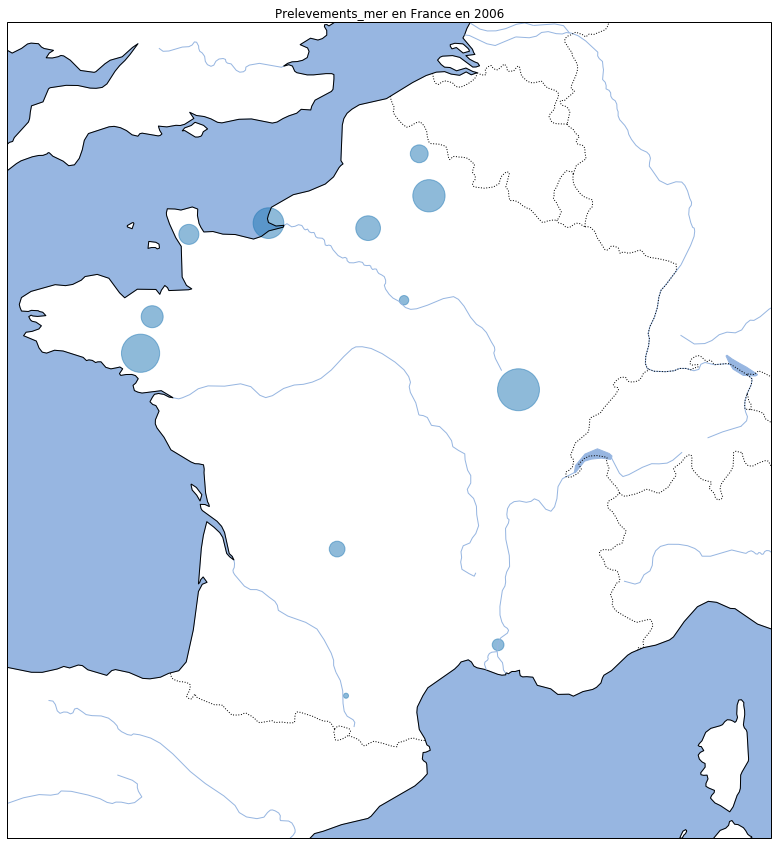

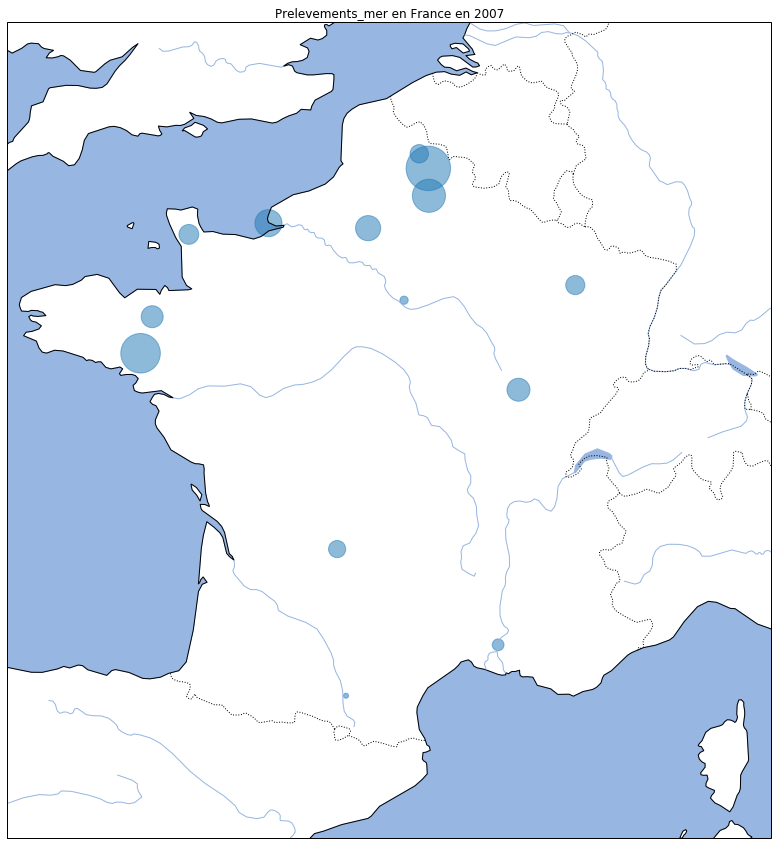

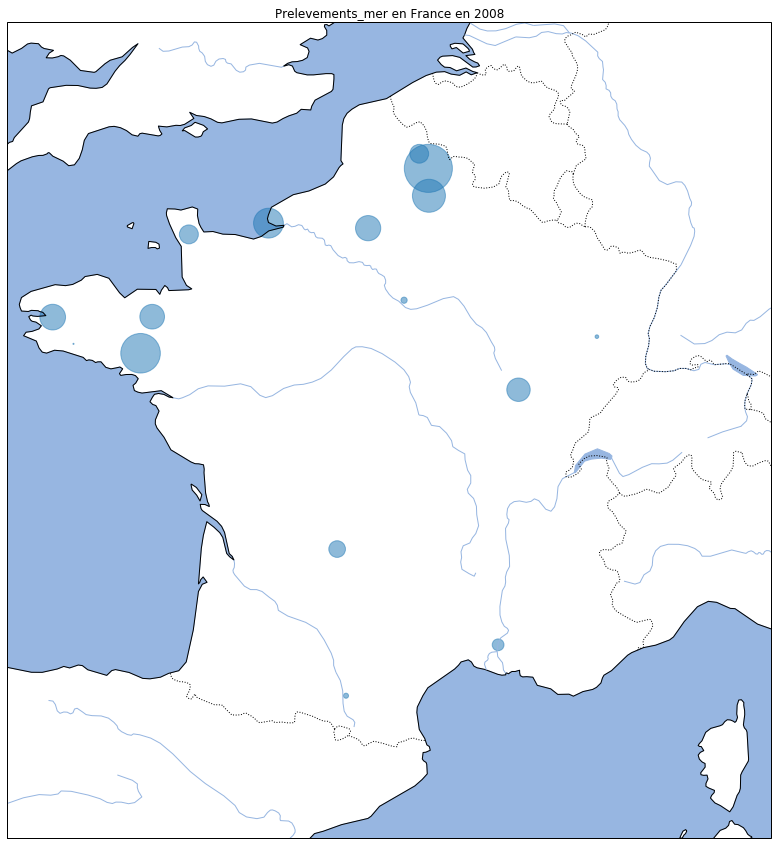

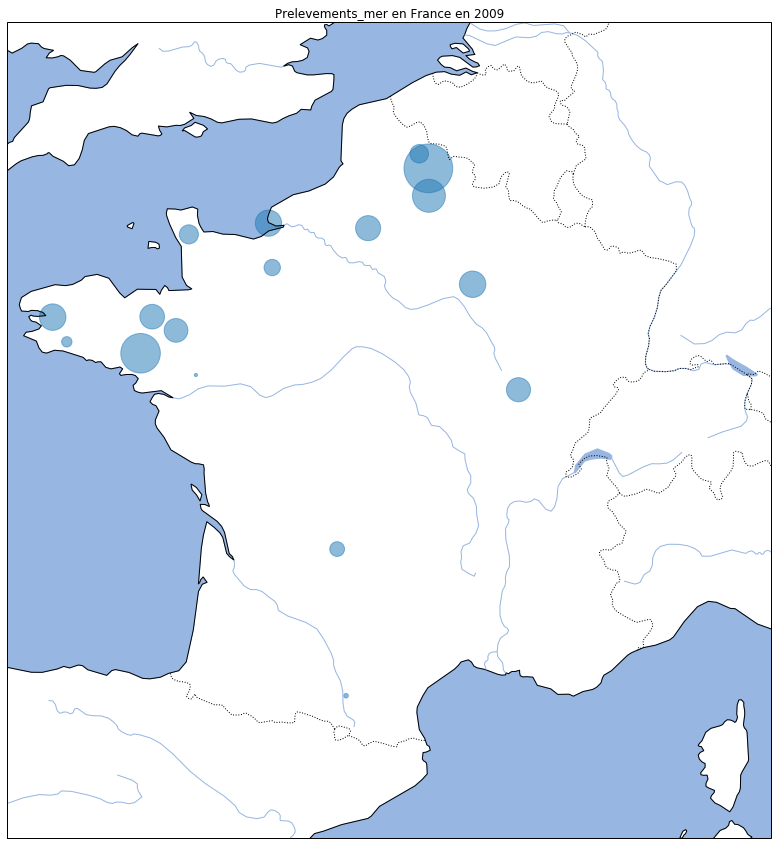

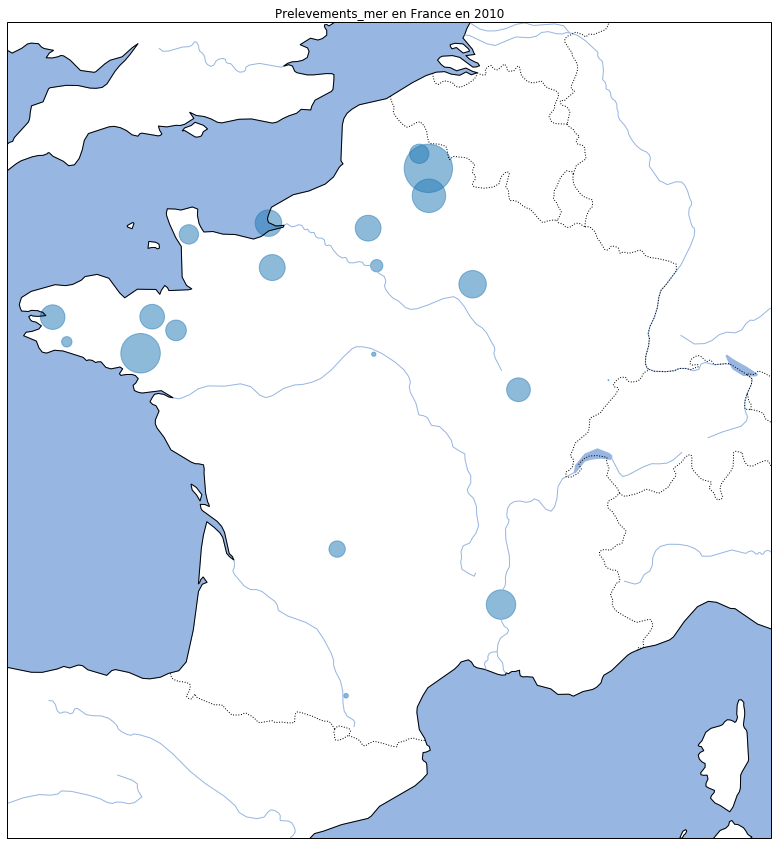

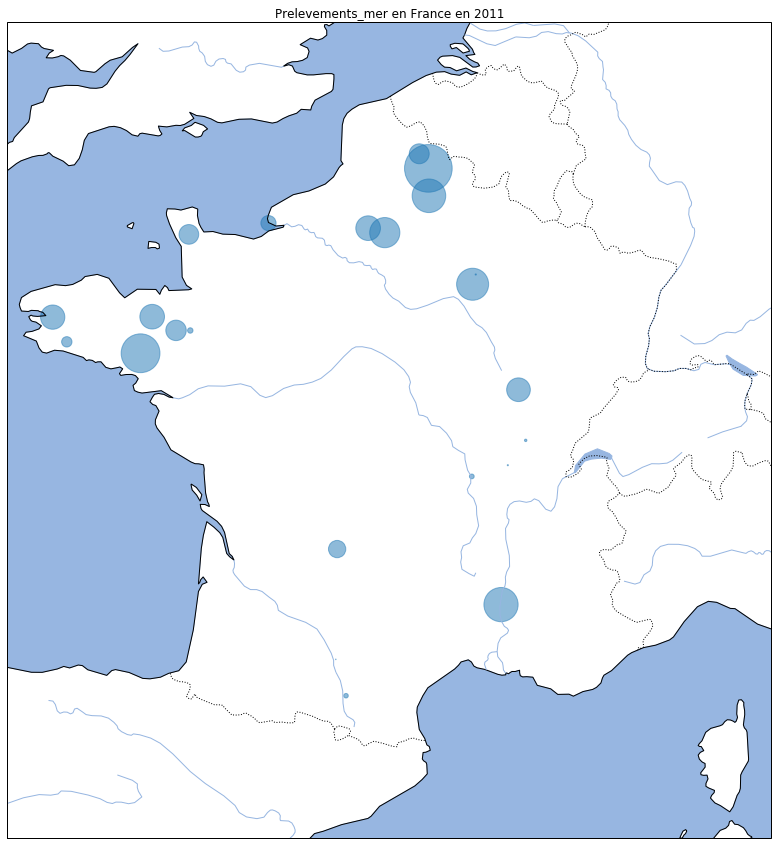

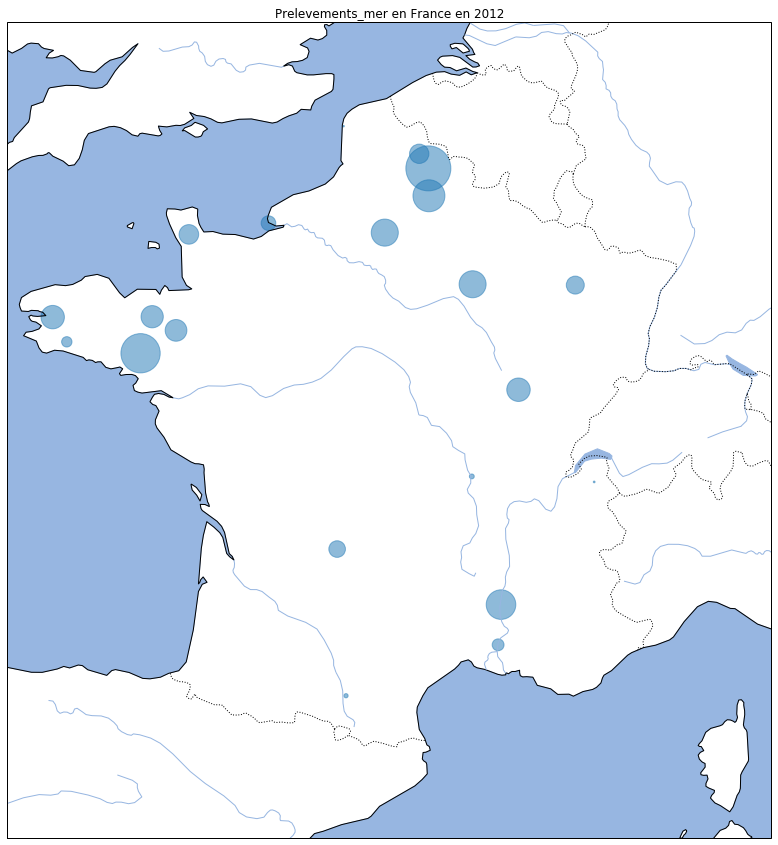

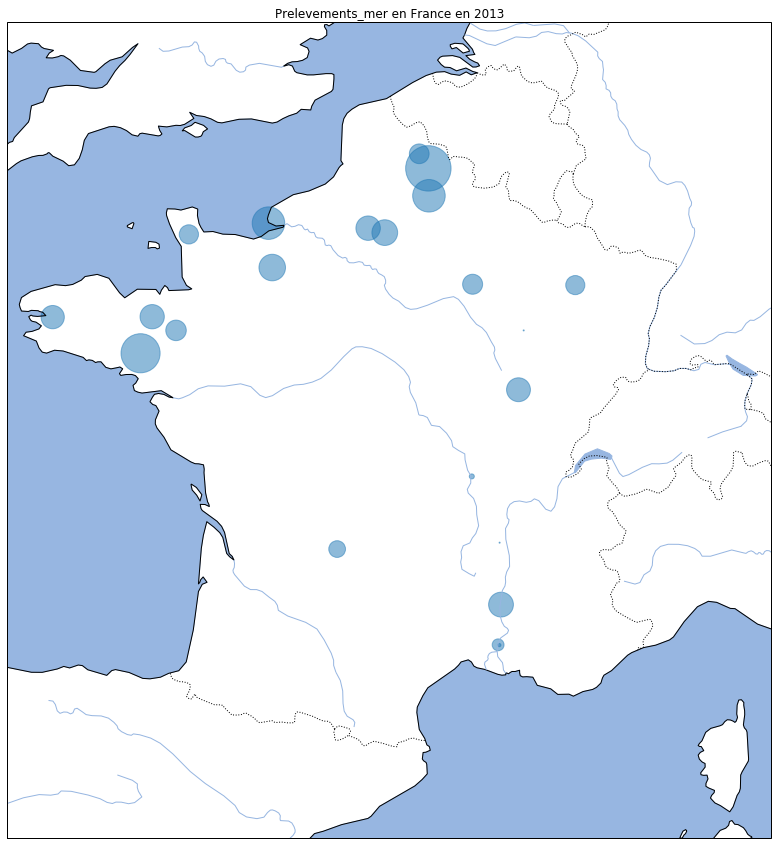

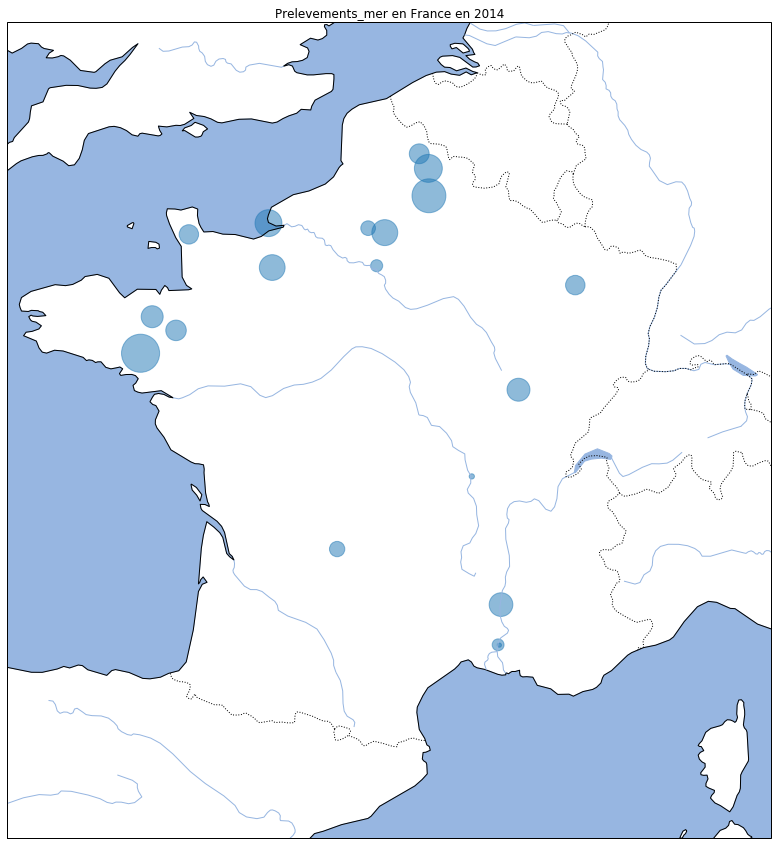

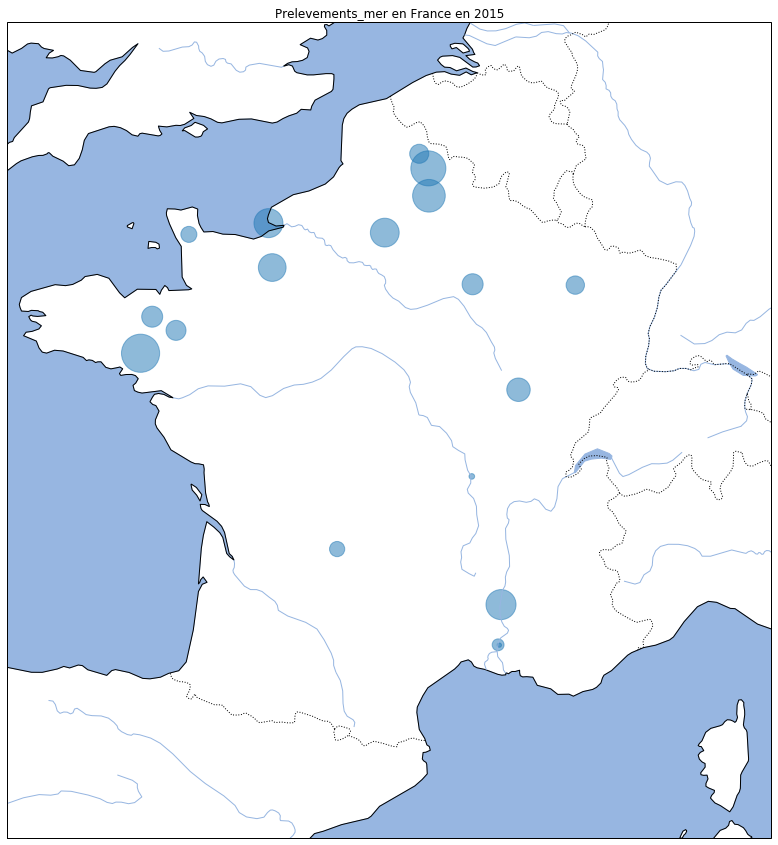

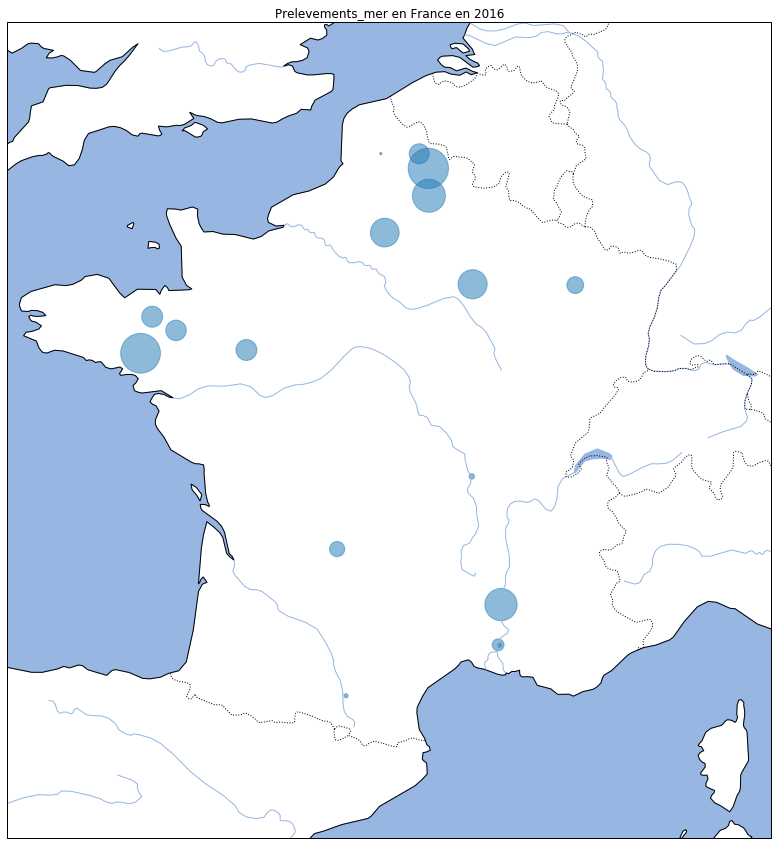

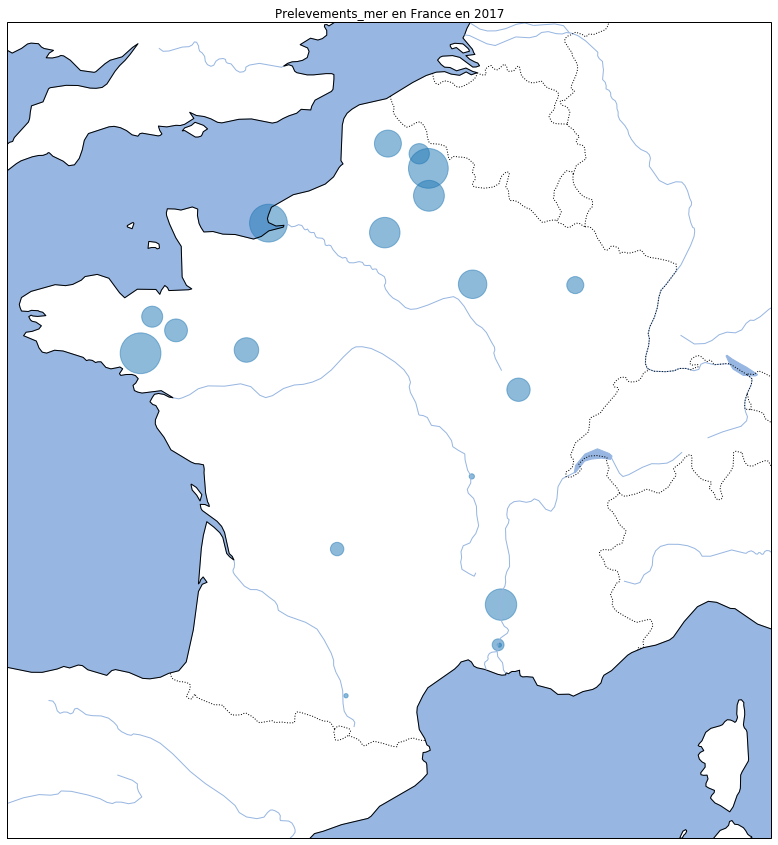

In [59]:
x1=df2.Coordonnees_X.values
y1=df2.Coordonnees_Y.values
hue1="Prelevements_mer"
years=range(2003,2018)
axis=[-5, 10, 41, 52]

ensae2019.plot_geo_time_value(x1, y1, years, df, hue1, proj="Mercator",axs=axis)